In [2]:
"""
r: Zongyi Li and Daniel Zhengyu Huang
"""

import numpy
import torch.nn.functional as F
import matplotlib.pyplot as plt
from timeit import default_timer
from catheter import *
from utilities3 import *
from Adam import Adam

torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("device is ", (device))

device is  cuda


In [3]:
def Lx2length(L_x, L_p, x1, x2, x3, x4, x5, h):
    # L_x position (positive)
    l0, l1, l2, l3, l4, l5 = -x3, torch.sqrt((x5-x3)**2 + (h/2)**2), torch.sqrt((x5-x2)**2 + (h/2)**2), torch.sqrt((x2-x4)**2 + (h/2)**2), torch.sqrt((x1-x4)**2 + (h/2)**2), L_p+x1
    if L_x < -x3:
        l = L_x
    elif L_x < -x5:
        l = l0 + l1*(L_x + x3)/(x3-x5)
    elif L_x < -x2:
        l = l0 + l1 + l2*(L_x + x5)/(x5-x2)
    elif L_x < -x4:
        l = l0 + l1 + l2 + l3*(L_x + x2)/(x2-x4)
    elif L_x < -x1:
        l = l0 + l1 + l2 + l3 + l4*(L_x + x4)/(x4-x1)
    else:
        l = l0 + l1 + l2 + l3 + l4 + L_x + x1

    return l

def d2xy(d, L_p, x1, x2, x3, x4, x5, h):
    
    p0, p1, p2, p3, p4, p5 = torch.tensor([0.0,0.0]), torch.tensor([x3,0.0]), torch.tensor([x5, h/2]), torch.tensor([x2, h]), torch.tensor([x4,h/2]), torch.tensor([x1,0.0])
    v0, v1, v2, v3, v4, v5 = torch.tensor([x3-0,0.0]), torch.tensor([x5-x3,h/2]), torch.tensor([x2-x5,h/2]), torch.tensor([x4-x2,-h/2]), torch.tensor([x1-x4,-h/2]), torch.tensor([-L_p-x1,0.0])
    l0, l1, l2, l3, l4, l5 = -x3, torch.sqrt((x5-x3)**2 + (h/2)**2), torch.sqrt((x5-x2)**2 + (h/2)**2), torch.sqrt((x2-x4)**2 + (h/2)**2), torch.sqrt((x1-x4)**2 + (h/2)**2), L_p+x1
    
    xx, yy = torch.zeros(d.shape), torch.zeros(d.shape)
    ind = (d < l0)
    xx[ind] = d[ind]*v0[0]/l0 + p0[0]
    yy[ind] = d[ind]*v0[1]/l0 + p0[1]
    
    ind = torch.logical_and(d < l0 + l1, d>=l0)
    xx[ind] = (d[ind]-l0)*v1[0]/l1 + p1[0] 
    yy[ind] = (d[ind]-l0)*v1[1]/l1 + p1[1]
    
    ind = torch.logical_and(d < l0 + l1 + l2, d>=l0 + l1)
    xx[ind] = (d[ind]-l0-l1)*v2[0]/l2 + p2[0]
    yy[ind] = (d[ind]-l0-l1)*v2[1]/l2 + p2[1]
    
    ind = torch.logical_and(d < l0 + l1 + l2 + l3, d>=l0 + l1 + l2)
    xx[ind] = (d[ind]-l0-l1-l2)*v3[0]/l3 + p3[0]
    yy[ind] = (d[ind]-l0-l1-l2)*v3[1]/l3 + p3[1]
    
    ind = torch.logical_and(d < l0 + l1 + l2 + l3 + l4, d>=l0 + l1 + l2 + l3)
    xx[ind] = (d[ind]-l0-l1-l2-l3)*v4[0]/l4 + p4[0]
    yy[ind] = (d[ind]-l0-l1-l2-l3)*v4[1]/l4 + p4[1]
    
    ind = (d>=l0 + l1 + l2 + l3 + l4)
    xx[ind] = (d[ind]-l0-l1-l2-l3-l4)*v5[0]/l5 + p5[0]
    yy[ind] = (d[ind]-l0-l1-l2-l3-l4)*v5[1]/l5 + p5[1]
    
    return xx, yy

def catheter_mesh_1d_total_length(L_x, L_p, x2, x3, x4, x5, h, N_s):
    x1 = -0.5*L_p
    # ncy = 20
    
    n_periods = torch.floor(L_x / L_p)
    L_x_last_period = L_x - n_periods*L_p
    L_p_s = (x1 + L_p) + (0 - x3) + torch.sqrt((x4 - x1)**2 + (h/2)**2) + torch.sqrt((x4 - x2)**2 + (h/2)**2) + torch.sqrt((x2 - x5)**2 + (h/2)**2) + torch.sqrt((x3 - x5)**2 + (h/2)**2)
    L_s = L_p_s*n_periods + Lx2length(L_x_last_period, L_p, x1, x2, x3, x4, x5, h)
    
    # from 0
    d_arr = torch.linspace(0, 1, N_s) * L_s
    
    # TODO do not compute gradient for floor
    period_arr = torch.floor(d_arr / L_p_s).detach()
    d_arr -= period_arr * L_p_s

    
    xx, yy = d2xy(d_arr, L_p, x1, x2, x3, x4, x5, h)

    xx = xx - period_arr*L_p
    
    
    X_Y = torch.zeros((1, N_s, 2), dtype=torch.float).to(device)
    X_Y[0, :, 0], X_Y[0, :, 1] = xx, yy
    return X_Y, xx, yy




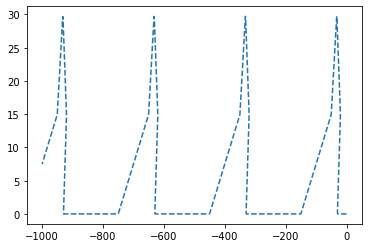

In [4]:
L_x, L_p, x2, x3, x4, x5, h = 1000, 300, -32, -30, -50, -20, 30
x1 = -0.5*L_p
N_s = 1001

L_p, x2, x3, x4, x5, h =  torch.tensor(L_p, dtype=torch.float), torch.tensor(x2, dtype=torch.float), torch.tensor(x3, dtype=torch.float), torch.tensor(x4, dtype=torch.float), torch.tensor(x5, dtype=torch.float), torch.tensor(h, dtype=torch.float)
X_Y, X, Y = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, x4, x5, h, N_s)


X_Y_numpy = X_Y.cpu().numpy()
plt.plot(X_Y_numpy[0, :, 0], X_Y_numpy[0, :, 1], "--")
# plt.xlim([-1000,-600])
# ##################################################
# # Prediction on a special design
# #################################################
# model = torch.load("catheter_plain_period_model_1d500", map_location=device)
# out = torch.clip(model(X_Y).squeeze(), min=0.0).detach().cpu().numpy()
# xx_mask = numpy.linspace(1.0, 0, n_periods*ncx+1) * (-L_p*n_periods)
# print("L_p, x1, x2, x3, h  = ", L_p, x1, x2, x3, h)
# print("loss = ",  -np.dot(out,xx_mask) )
# plt.figure()
# plt.plot(xx_mask, out)


1336001
initialize :  (tensor(100., grad_fn=<AddBackward0>), tensor(-50., grad_fn=<MulBackward0>), tensor(-30., grad_fn=<AddBackward0>), tensor(-30., grad_fn=<AddBackward0>), tensor(-50., grad_fn=<AddBackward0>), tensor(-30., grad_fn=<AddBackward0>), tensor(25., grad_fn=<AddBackward0>))
0 0.026843871921300888 loss =  531229.1875
L_p, x1, x2, x3, x4, x5, h  =  100.0 -50.0 -30.0 -30.0 -50.0 -30.0 25.0


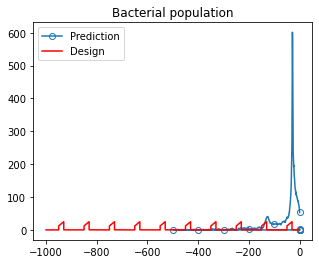

200 0.012494747992604971 loss =  449199.9375
L_p, x1, x2, x3, x4, x5, h  =  91.62371063232422 -45.81185531616211 -22.905384063720703 -26.275516510009766 -49.178001403808594 -30.871583938598633 25.703088760375977


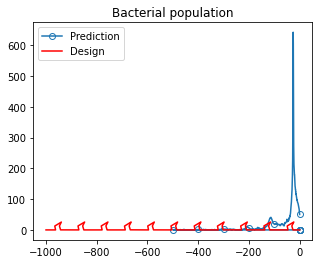

400 0.013113745953887701 loss =  371572.78125
L_p, x1, x2, x3, x4, x5, h  =  84.1270751953125 -42.06353759765625 -16.779399871826172 -23.08295249938965 -48.30712127685547 -31.268949508666992 26.347248077392578


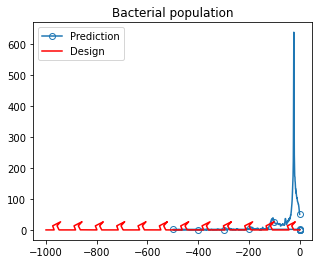

600 0.012345661409199238 loss =  337066.84375
L_p, x1, x2, x3, x4, x5, h  =  78.40367126464844 -39.20183563232422 -12.523309707641602 -20.88098907470703 -47.458656311035156 -31.21729278564453 26.884342193603516


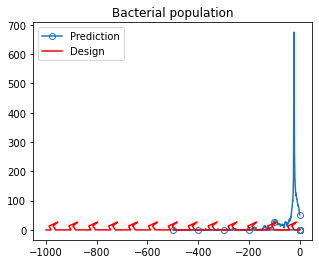

800 0.023205779027193785 loss =  237480.859375
L_p, x1, x2, x3, x4, x5, h  =  73.63817596435547 -36.819087982177734 -9.531379699707031 -19.19740104675293 -46.27235412597656 -30.520292282104492 27.281404495239258


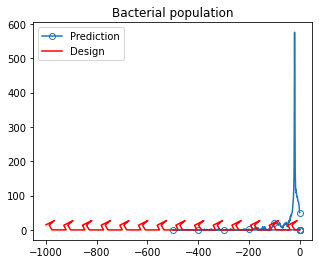

1000 0.012604853138327599 loss =  287426.71875
L_p, x1, x2, x3, x4, x5, h  =  70.46375274658203 -35.231876373291016 -7.428438186645508 -18.118637084960938 -45.52055740356445 -30.043411254882812 27.556087493896484


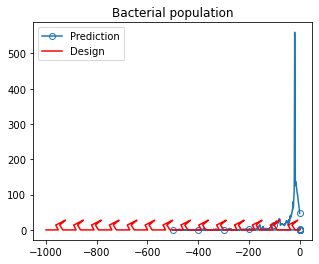

1200 0.03338359575718641 loss =  286168.65625
L_p, x1, x2, x3, x4, x5, h  =  70.20439910888672 -35.10219955444336 -7.259147644042969 -18.032814025878906 -45.45598602294922 -29.998964309692383 27.57657241821289


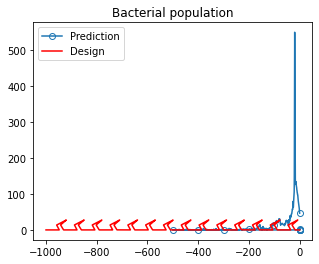

1400 0.02297228155657649 loss =  285739.65625
L_p, x1, x2, x3, x4, x5, h  =  69.95865631103516 -34.97932815551758 -7.100032806396484 -17.95193099975586 -45.39391326904297 -29.955589294433594 27.594297409057617


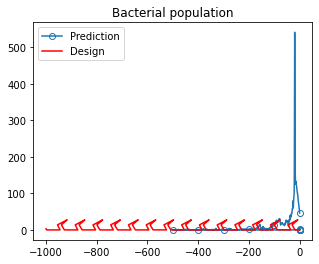

1600 0.033334326930344105 loss =  286693.25
L_p, x1, x2, x3, x4, x5, h  =  69.7343978881836 -34.8671989440918 -6.948169708251953 -17.87809944152832 -45.34487533569336 -29.923728942871094 27.610244750976562


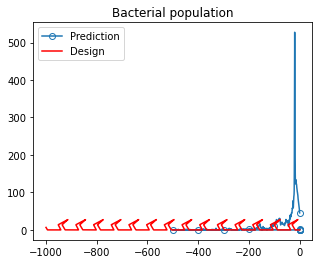

1800 0.022889599669724703 loss =  287899.5625
L_p, x1, x2, x3, x4, x5, h  =  69.53094482421875 -34.765472412109375 -6.802036285400391 -17.810964584350586 -45.31157684326172 -29.90631866455078 27.6248779296875


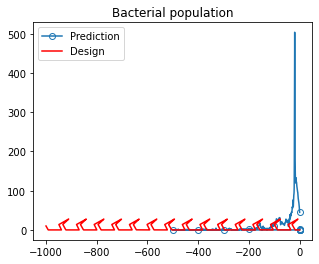

2000 0.02300508413463831 loss =  289111.4375
L_p, x1, x2, x3, x4, x5, h  =  69.34504699707031 -34.672523498535156 -6.660943984985352 -17.749431610107422 -45.29188919067383 -29.901376724243164 27.636905670166016


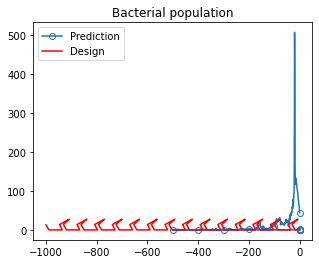

2200 0.023260468617081642 loss =  289199.03125
L_p, x1, x2, x3, x4, x5, h  =  69.3274917602539 -34.66374588012695 -6.647056579589844 -17.74359703063965 -45.29087448120117 -29.901769638061523 27.637737274169922


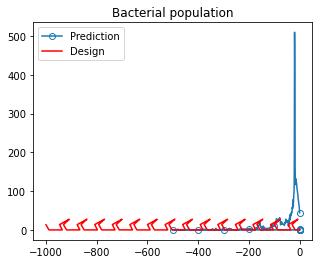

2400 0.025019918102771044 loss =  289280.90625
L_p, x1, x2, x3, x4, x5, h  =  69.3104248046875 -34.65521240234375 -6.633264541625977 -17.73790740966797 -45.29037094116211 -29.90264320373535 27.6380672454834


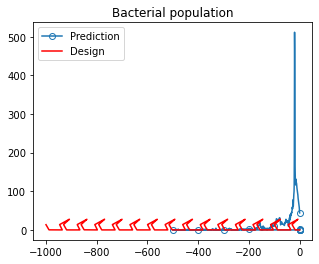

2600 0.024519445840269327 loss =  289364.625
L_p, x1, x2, x3, x4, x5, h  =  69.2936782836914 -34.6468391418457 -6.619647979736328 -17.732309341430664 -45.29021072387695 -29.903841018676758 27.637775421142578


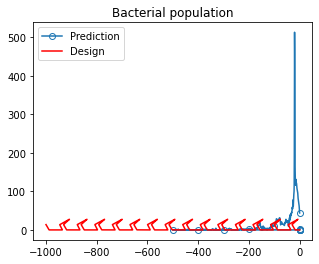

2800 0.03383754985406995 loss =  280708.71875
L_p, x1, x2, x3, x4, x5, h  =  69.27613067626953 -34.638065338134766 -6.605897903442383 -17.726476669311523 -45.2892951965332 -29.904314041137695 27.63652801513672


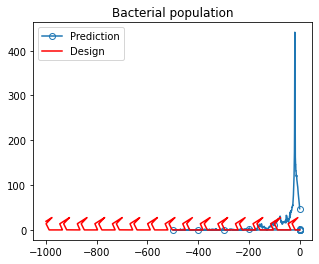

3000 0.03650630032643676 loss =  280532.59375
L_p, x1, x2, x3, x4, x5, h  =  69.25627899169922 -34.62813949584961 -6.591770172119141 -17.719980239868164 -45.28620910644531 -29.902711868286133 27.633834838867188


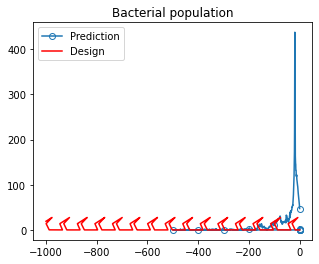

3200 0.01256326911970973 loss =  280513.75
L_p, x1, x2, x3, x4, x5, h  =  69.25418090820312 -34.62709045410156 -6.590333938598633 -17.71929931640625 -45.285736083984375 -29.902395248413086 27.633424758911133


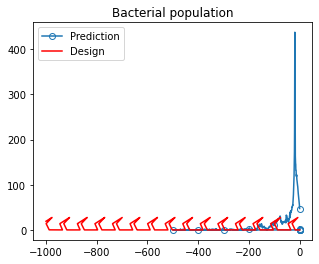

3400 0.02840380184352398 loss =  280496.09375
L_p, x1, x2, x3, x4, x5, h  =  69.25208282470703 -34.626041412353516 -6.588901519775391 -17.718618392944336 -45.28526306152344 -29.902076721191406 27.632915496826172


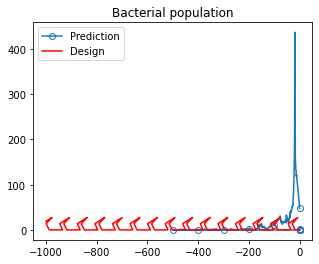

3600 0.03377711772918701 loss =  280473.53125
L_p, x1, x2, x3, x4, x5, h  =  69.24958801269531 -34.624794006347656 -6.58741569519043 -17.717823028564453 -45.28443908691406 -29.901426315307617 27.632356643676758


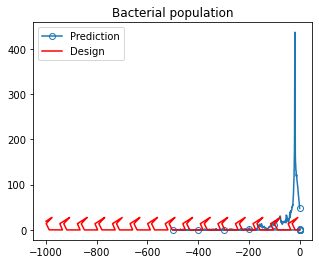

3800 0.023182725999504328 loss =  280450.71875
L_p, x1, x2, x3, x4, x5, h  =  69.2470703125 -34.62353515625 -6.585926055908203 -17.717018127441406 -45.28356170654297 -29.900720596313477 27.631797790527344


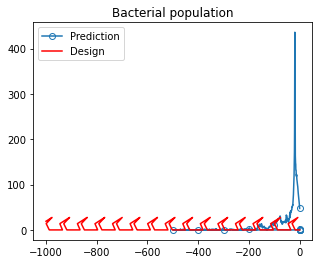

4000 0.02378101972863078 loss =  280427.90625
L_p, x1, x2, x3, x4, x5, h  =  69.24456024169922 -34.62228012084961 -6.584442138671875 -17.716217041015625 -45.28268814086914 -29.900020599365234 27.631237030029297


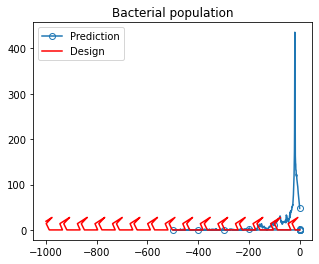

4200 0.028508630581200123 loss =  280423.4375
L_p, x1, x2, x3, x4, x5, h  =  69.244140625 -34.6220703125 -6.584257125854492 -17.71608543395996 -45.28254318237305 -29.899900436401367 27.631193161010742


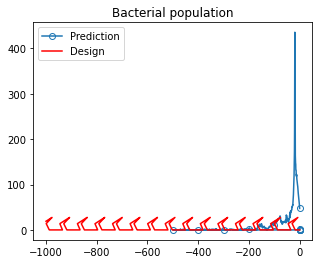

4400 0.02624691417440772 loss =  280418.875
L_p, x1, x2, x3, x4, x5, h  =  69.24372100830078 -34.62186050415039 -6.584070205688477 -17.715953826904297 -45.28229522705078 -29.899677276611328 27.631149291992188


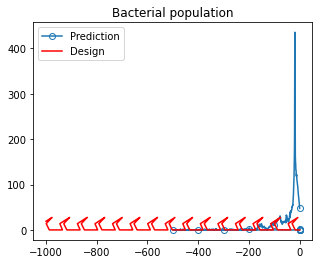

4600 0.012887118849903345 loss =  280414.0
L_p, x1, x2, x3, x4, x5, h  =  69.24330139160156 -34.62165069580078 -6.583887100219727 -17.715824127197266 -45.282020568847656 -29.89942741394043 27.631107330322266


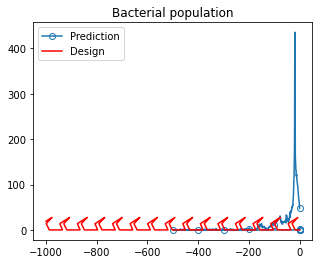

4800 0.012588255107402802 loss =  280409.40625
L_p, x1, x2, x3, x4, x5, h  =  69.24288177490234 -34.62144088745117 -6.583700180053711 -17.7156925201416 -45.28174591064453 -29.89917755126953 27.63106346130371


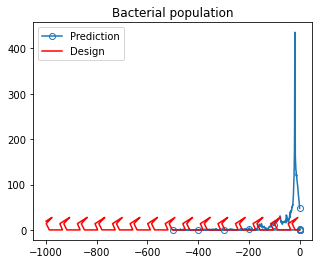

In [ ]:
################################################################
# inverse optimization for 1d
################################################################


model = torch.load("catheter_plain_length_model_1d1000", map_location=device)
print(count_params(model))


learning_rate = 0.001
epochs = 5001
step_size = 1000
gamma = 0.1


# constraints   
#               60 < L_p < 250
#               x1 = -0.5L_p 
#               -L_p/4 < x2 - x1 < L_p/4
#               15 < x3 - x1 < L_p/4
#               20 < h < 30
# def transfer(theta):
    
#     L_p = 60 + (250 - 60)/(1 + torch.abs(theta[0]))
#     x1 = -0.5*L_p
#     x2 = x1  - L_p/4 + (L_p/2)/(1 + torch.abs(theta[1]))
#     x3 = x1  + 15 + (L_p/4 - 15)/(1 + torch.abs(theta[2]))
#     h = 20   + (10)/(1 + torch.abs(theta[3]))
#     return L_p, x1, x2, x3, h

# def inv_transfer(L_p, x2, x3, h):
#     x1 = -0.5*L_p
#     theta = np.zeros(4)
#     theta[0] = (250 - 60)/(L_p - 60) - 1
#     theta[1] = (L_p/2)/(x2 - x1  + L_p/4) - 1
#     theta[2] = (L_p/4 - 15)/(x3 - x1  - 15) - 1
#     theta[3] = 10/(h - 20 ) - 1
#     return theta


# constraints   
#               60 < L_p < 250
#               x1 = -0.5L_p 
#               
#               15 < x3 - x1 < L_p/4
#           -L_p/4 < x2 - x3 < L_p/4
#               20 < h  < 30
#           -L_p/4 < x4 - x1 < L_p/4    
#               15 < x5 - x4 < L_p/4
#
# def transfer(theta):
def transfer(theta):
    
    L_p = 60 + (250 - 60)/(1 + torch.exp(theta[0]))
    x1 = -0.5*L_p
    x3 = x1  + 15 + (L_p/4 - 15)/(1 + torch.exp(theta[2]))
    x2 = x3  - L_p/4 + (L_p/2)/(1 + torch.exp(theta[1]))
    #
    x4 = x1  - L_p/4 + (L_p/2)/(1 + torch.exp(theta[4]))
    x5 = x4  + 15 + (L_p/4 - 15)/(1 + torch.exp(theta[5]))
    h = 20   + (10)/(1 + torch.exp(theta[3]))
    return L_p, x1, x2, x3, x4, x5, h


def inv_transfer(L_p, x2, x3, x4, x5, h):
    x1 = -0.5*L_p
    theta = np.zeros(6)
    theta[0] = np.log( (250 - 60)/(L_p - 60) - 1 )
    theta[1] = np.log( (L_p/2)/(x2 - x3  + L_p/4) - 1 )
    theta[2] = np.log( (L_p/4 - 15)/(x3 - x1  - 15) - 1 )
    
    theta[4] = np.log( (L_p/2)/(x4 - x1  + L_p/4) - 1 )
    theta[5] = np.log( (L_p/4 - 15)/(x5 - x4  - 15) - 1 )    
    
    theta[3] = np.log( 10/(h - 20 ) - 1 )
    return theta


L_p, x2, x3, x4, x5, h = 100.0, -30.0, -30.0, -50.0, -30.0, 25.0, 

theta0 =    inv_transfer(L_p, x2, x3, x4, x5, h) 


theta = torch.tensor(theta0.astype(np.float32) , requires_grad=True)
print("initialize : ", transfer(theta))

optimizer = Adam([theta], lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = LpLoss(size_average=False)


L_x = 1000
N_s = 2001
xx_mask = (torch.linspace(1.0, 0, N_s) * (-L_x)).to(device)
xx_mask[0:1000] = 0.0
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    
    L_p, x1, x2, x3, x4, x5, h = transfer(theta)
    x, XC, YC = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, x4, x5, h, N_s)
    
    out = torch.clip(model(x).squeeze(), min=0.0)
    # maximize negative mean
    loss = -torch.sum(torch.matmul(out, xx_mask))* L_x/N_s
    
    loss.backward()
    optimizer.step()
    scheduler.step()

    t2 = default_timer()
    
    if ep%200==0:
        print(ep, t2 - t1,  "loss = ", loss.item())

        mesh = x.detach().cpu().numpy()
        print("L_p, x1, x2, x3, x4, x5, h  = ", L_p.item(), x1.item(), x2.item(), x3.item(), x4.item(), x5.item(), h.item())
        plt.figure(figsize=(5,4))
        plt.title("Bacterial population")
        plt.plot(xx_mask.detach().cpu().numpy(), out.detach().cpu().numpy().T, "-o", fillstyle='none', markevery=len(xx_mask)//10, label="Prediction")
        plt.plot(mesh[0, :, 0], mesh[0, :, 1], color="r", label="Design")
        
        plt.legend()
        plt.show()
#         plt.savefig("Catheter."+str(ep).zfill(5)+".pdf")

1336001
initialize :  (tensor(100., grad_fn=<AddBackward0>), tensor(-50., grad_fn=<MulBackward0>), tensor(-30., grad_fn=<AddBackward0>), tensor(-30., grad_fn=<AddBackward0>), tensor(-50., grad_fn=<AddBackward0>), tensor(-30., grad_fn=<AddBackward0>), tensor(25., grad_fn=<AddBackward0>))
0 0.4029110614210367 loss =  299354.1875 loss_min =  inf
tensor([ 2.2294, -1.6835,  1.7979, -0.1432,  0.8835,  0.7430],
       grad_fn=<CloneBackward0>)
L_p, x1, x2, x3, x4, x5, h  =  78.45724487304688 -39.22862243652344 -12.288856506347656 -20.785634994506836 -55.51171112060547 -37.61699295043945 25.357393264770508


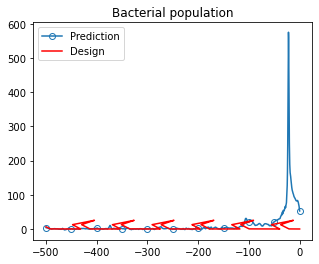

1 0.27628621831536293 loss =  394444.78125 loss_min =  299354.1875
2 0.27394552156329155 loss =  551601.1875 loss_min =  299354.1875
3 0.29708489775657654 loss =  425881.1875 loss_min =  299354.1875
4 0.2936653234064579 loss =  359966.03125 loss_min =  299354.1875
5 0.27877949364483356 loss =  451883.1875 loss_min =  299354.1875
6 0.28118972294032574 loss =  395433.375 loss_min =  299354.1875
7 0.2992620952427387 loss =  451621.21875 loss_min =  299354.1875
8 0.2750912755727768 loss =  194479.734375 loss_min =  299354.1875
tensor([ 3.9773, -2.0771,  0.4162, -1.1681,  0.1823,  1.3562],
       grad_fn=<CloneBackward0>)
L_p, x1, x2, x3, x4, x5, h  =  63.49435806274414 -31.74717903137207 -7.069446563720703 -10.091529846191406 -34.632755279541016 -27.538082122802734 27.62801742553711


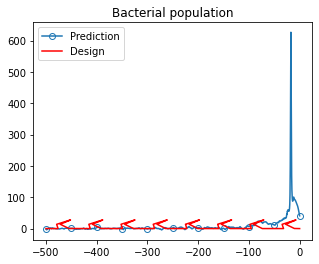

9 0.289188576862216 loss =  248813.046875 loss_min =  194479.734375
10 0.28911079838871956 loss =  196520.40625 loss_min =  194479.734375
11 0.2935504447668791 loss =  632566.3125 loss_min =  194479.734375
12 0.2769366279244423 loss =  330362.625 loss_min =  194479.734375
13 0.27682470716536045 loss =  502791.75 loss_min =  194479.734375
14 0.2866976000368595 loss =  277930.15625 loss_min =  194479.734375
15 0.2570387627929449 loss =  421307.03125 loss_min =  194479.734375
16 0.2927316315472126 loss =  619412.125 loss_min =  194479.734375
17 0.2536522261798382 loss =  351010.625 loss_min =  194479.734375
18 0.2742592357099056 loss =  163171.96875 loss_min =  194479.734375
tensor([ 5.0813, -2.9021,  0.1977, -0.2632,  0.1721,  1.7295],
       grad_fn=<CloneBackward0>)
L_p, x1, x2, x3, x4, x5, h  =  61.17294692993164 -30.58647346496582 -3.1839065551757812 -8.561182022094727 -33.212127685546875 -28.20868492126465 25.654186248779297


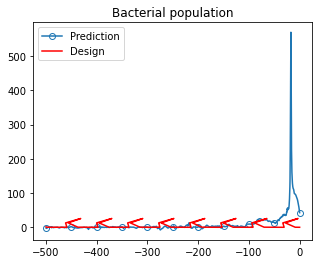

19 0.2675256226211786 loss =  201370.046875 loss_min =  163171.96875
20 0.2556107547134161 loss =  246599.171875 loss_min =  163171.96875
21 0.2712271884083748 loss =  291875.1875 loss_min =  163171.96875
22 0.2723532561212778 loss =  405060.75 loss_min =  163171.96875
23 0.2948475759476423 loss =  229026.21875 loss_min =  163171.96875
24 0.271087346598506 loss =  356409.125 loss_min =  163171.96875
25 0.2723083570599556 loss =  479610.65625 loss_min =  163171.96875
26 0.2778187859803438 loss =  452884.0 loss_min =  163171.96875
27 0.25472818315029144 loss =  243594.96875 loss_min =  163171.96875
28 0.2720623556524515 loss =  368080.84375 loss_min =  163171.96875
29 0.2868422195315361 loss =  773891.375 loss_min =  163171.96875
30 0.2726992294192314 loss =  183669.3125 loss_min =  163171.96875
31 0.27821495197713375 loss =  186500.484375 loss_min =  163171.96875
32 0.27810775861144066 loss =  321140.9375 loss_min =  163171.96875
33 0.3036394212394953 loss =  723533.375 loss_min =  1631

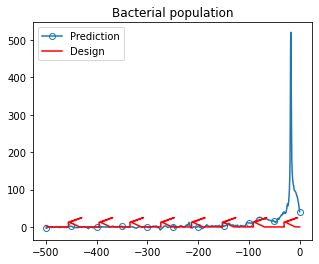

41 0.30601012147963047 loss =  729591.875 loss_min =  161542.609375
42 0.27094847336411476 loss =  356191.34375 loss_min =  161542.609375
43 0.2960091233253479 loss =  791670.5625 loss_min =  161542.609375
44 0.3122087959200144 loss =  356225.21875 loss_min =  161542.609375
45 0.27463669143617153 loss =  461279.75 loss_min =  161542.609375
46 0.2527253217995167 loss =  226302.625 loss_min =  161542.609375
47 0.2998956684023142 loss =  474005.34375 loss_min =  161542.609375
48 0.29161668941378593 loss =  340006.9375 loss_min =  161542.609375
49 0.29417772591114044 loss =  300509.4375 loss_min =  161542.609375
50 0.25375192798674107 loss =  391901.6875 loss_min =  161542.609375
51 0.2714560851454735 loss =  332470.21875 loss_min =  161542.609375
52 0.2866177186369896 loss =  253227.109375 loss_min =  161542.609375
53 0.29067342542111874 loss =  252339.15625 loss_min =  161542.609375
54 0.2976931370794773 loss =  759995.875 loss_min =  161542.609375
55 0.25350623205304146 loss =  168494.7

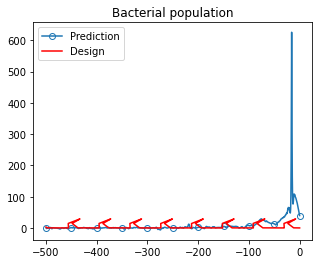

73 0.2928641326725483 loss =  397221.53125 loss_min =  151384.640625
74 0.3086763881146908 loss =  224327.5625 loss_min =  151384.640625
75 0.3035451006144285 loss =  147080.328125 loss_min =  151384.640625
tensor([ 6.5607, -2.6726,  2.2290, -2.9073, -0.4870,  2.5381],
       grad_fn=<CloneBackward0>)
L_p, x1, x2, x3, x4, x5, h  =  60.268463134765625 -30.134231567382812 -3.8937835693359375 -13.663518905639648 -22.937938690185547 -21.258214950561523 29.482059478759766


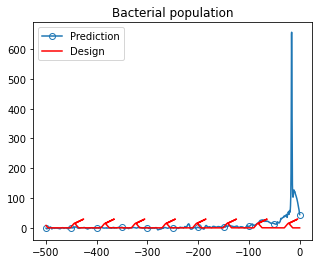

76 0.26255438663065434 loss =  276352.75 loss_min =  147080.328125
77 0.2998816929757595 loss =  160255.09375 loss_min =  147080.328125
78 0.3086507711559534 loss =  595293.9375 loss_min =  147080.328125
79 0.28875729627907276 loss =  746962.3125 loss_min =  147080.328125
80 0.30117814242839813 loss =  473600.59375 loss_min =  147080.328125
81 0.27862067706882954 loss =  225501.3125 loss_min =  147080.328125
82 0.29868133552372456 loss =  355393.71875 loss_min =  147080.328125
83 0.25453881919384 loss =  827752.75 loss_min =  147080.328125
84 0.2864948958158493 loss =  722334.75 loss_min =  147080.328125
85 0.28695259988307953 loss =  111086.8203125 loss_min =  147080.328125
tensor([ 8.2836, -2.5664,  0.7432, -2.7527, -0.0680,  2.6824],
       grad_fn=<CloneBackward0>)
L_p, x1, x2, x3, x4, x5, h  =  60.04798889160156 -30.02399444580078 -4.283294677734375 -10.181692123413086 -29.003456115722656 -27.14667320251465 29.400680541992188


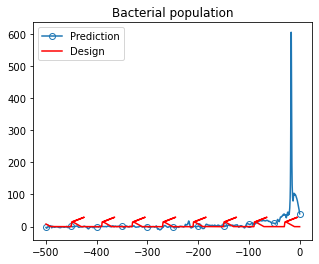

86 0.3035275563597679 loss =  701334.875 loss_min =  111086.8203125
87 0.30450244806706905 loss =  675442.0625 loss_min =  111086.8203125
88 0.28464651107788086 loss =  498426.34375 loss_min =  111086.8203125
89 0.16649920865893364 loss =  241613.390625 loss_min =  111086.8203125
90 0.29899121448397636 loss =  243146.09375 loss_min =  111086.8203125
91 0.301376985386014 loss =  145944.890625 loss_min =  111086.8203125
92 0.3036979306489229 loss =  602902.9375 loss_min =  111086.8203125
93 0.25446489080786705 loss =  136749.75 loss_min =  111086.8203125
94 0.303859606385231 loss =  176122.109375 loss_min =  111086.8203125
95 0.29173486307263374 loss =  634651.25 loss_min =  111086.8203125
96 0.3109597284346819 loss =  508530.875 loss_min =  111086.8203125
97 0.30546456202864647 loss =  207717.78125 loss_min =  111086.8203125
98 0.29878902807831764 loss =  554516.0625 loss_min =  111086.8203125
99 0.260155389085412 loss =  128602.34375 loss_min =  111086.8203125
100 0.25440073758363724 l

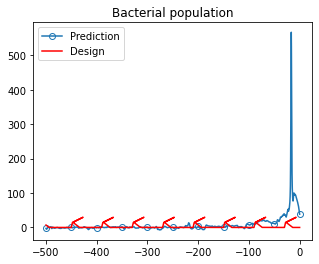

132 0.2539233211427927 loss =  123373.4453125 loss_min =  108725.671875
133 0.27287878654897213 loss =  141672.90625 loss_min =  108725.671875
134 0.2771523520350456 loss =  369137.34375 loss_min =  108725.671875
135 0.27187023498117924 loss =  240734.234375 loss_min =  108725.671875
136 0.2556527741253376 loss =  217133.46875 loss_min =  108725.671875
137 0.26168324053287506 loss =  676470.8125 loss_min =  108725.671875
138 0.16659624688327312 loss =  460702.90625 loss_min =  108725.671875
139 0.23689964041113853 loss =  211401.28125 loss_min =  108725.671875
140 0.24199066683650017 loss =  646898.1875 loss_min =  108725.671875
141 0.12615538202226162 loss =  186349.953125 loss_min =  108725.671875
142 0.24161416850984097 loss =  366892.5625 loss_min =  108725.671875
143 0.23892647214233875 loss =  345761.6875 loss_min =  108725.671875
144 0.16213474795222282 loss =  268588.90625 loss_min =  108725.671875
145 0.23709294945001602 loss =  163347.09375 loss_min =  108725.671875
146 0.144

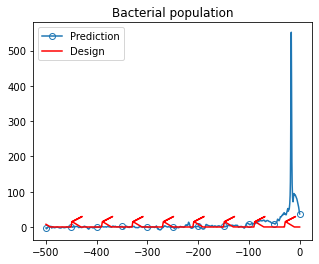

261 0.28058502078056335 loss =  353834.15625 loss_min =  108043.8203125
262 0.26301076635718346 loss =  154459.296875 loss_min =  108043.8203125
263 0.28402829356491566 loss =  560418.0625 loss_min =  108043.8203125
264 0.24005617015063763 loss =  103028.828125 loss_min =  108043.8203125
tensor([ 8.5112, -2.3693, -0.0913, -3.8341, -0.1598,  4.3335],
       grad_fn=<CloneBackward0>)
L_p, x1, x2, x3, x4, x5, h  =  60.0382194519043 -30.01910972595215 -5.136009216308594 -7.167004585266113 -27.625289916992188 -27.267498016357422 29.788360595703125


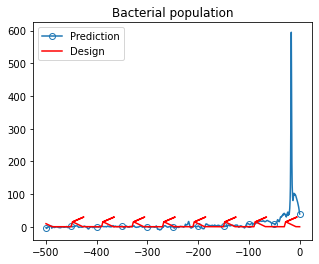

265 0.2568101491779089 loss =  293811.71875 loss_min =  103028.828125
266 0.25702373683452606 loss =  104461.6796875 loss_min =  103028.828125
267 0.28129762038588524 loss =  808734.1875 loss_min =  103028.828125
268 0.26658012345433235 loss =  198380.515625 loss_min =  103028.828125
269 0.2570882085710764 loss =  102529.9375 loss_min =  103028.828125
tensor([ 8.0789, -2.0757,  0.4899, -3.4230, -0.1815,  4.5941],
       grad_fn=<CloneBackward0>)
L_p, x1, x2, x3, x4, x5, h  =  60.05888366699219 -30.029441833496094 -6.695331573486328 -9.319409370422363 -27.312297821044922 -27.038908004760742 29.68414306640625


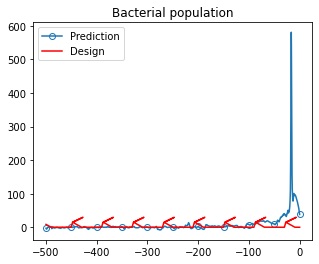

270 0.2577716801315546 loss =  105343.5703125 loss_min =  102529.9375
271 0.16396178305149078 loss =  325452.09375 loss_min =  102529.9375
272 0.3020761627703905 loss =  137569.671875 loss_min =  102529.9375
273 0.31916556879878044 loss =  517366.375 loss_min =  102529.9375
274 0.31163428351283073 loss =  237702.390625 loss_min =  102529.9375
275 0.3120222110301256 loss =  179173.609375 loss_min =  102529.9375
276 0.3127677720040083 loss =  107922.7421875 loss_min =  102529.9375
277 0.3126569800078869 loss =  321317.25 loss_min =  102529.9375
278 0.31313102319836617 loss =  336949.1875 loss_min =  102529.9375
279 0.29390558414161205 loss =  225170.6875 loss_min =  102529.9375
280 0.29305694065988064 loss =  144627.765625 loss_min =  102529.9375
281 0.3356396444141865 loss =  833341.625 loss_min =  102529.9375
282 0.3440797608345747 loss =  786174.0 loss_min =  102529.9375
283 0.3369557671248913 loss =  743808.3125 loss_min =  102529.9375
284 0.31732352636754513 loss =  548142.1875 loss

In [8]:
################################################################
# inverse optimization for 1d
################################################################


model = torch.load("catheter_plain_length_model_1d1000", map_location=device)
print(count_params(model))


epochs = 500


# constraints   
#               60 < L_p < 250
#               x1 = -0.5L_p 
#               
#               15 < x3 - x1 < L_p/2
#             -L_p < x2      < 0
#               20 < h       < 30
#             -L_p < x4  < -dx5_x4
#             dx5_x4 < x5 - x4  < 0 - x4 (dx5_x4 + x4 < x5 < 0)
# def transfer(theta):

dx5_x4 = 0

def transfer(theta):
    
    L_p = 60 + (250 - 60)/(1 + torch.exp(theta[0]))
    x1 = -0.5*L_p
    x3 = x1  + 15 + (L_p/2 - 15)/(1 + torch.exp(theta[2]))
    x2 = -L_p  + L_p/(1 + torch.exp(theta[1]))
    h = 20   + (10)/(1 + torch.exp(theta[3]))
    #
    x4 = -L_p  + (-dx5_x4 + L_p)/(1 + torch.exp(theta[4]))
    x5 = x4  + dx5_x4 + (-x4 - dx5_x4)/(1 + torch.exp(theta[5]))

    return L_p, x1, x2, x3, x4, x5, h


def inv_transfer(L_p, x2, x3, x4, x5, h):
    x1 = -0.5*L_p
    theta = np.zeros(6)

    theta[0] = np.log( (250 - 60)/(L_p - 60) - 1 )
    theta[1] = np.log( L_p/(x2 + L_p) - 1 )
    theta[2] = np.log( (L_p/2 - 15)/(x3 - x1  - 15) - 1 )
    theta[3] = np.log( 10/(h - 20 ) - 1 )
    
    theta[4] = np.log( (-dx5_x4 + L_p)/(x4 + L_p) - 1 )
    theta[5] = np.log( (-x4 - dx5_x4)/(x5 - x4  - dx5_x4) - 1 )    
    
    return theta


L_p, x2, x3, x4, x5, h = 100.0, -30.0, -30.0, -50.0, -30.0, 25.0, 

theta0 =    inv_transfer(L_p, x2, x3, x4, x5, h) 


theta = torch.tensor(theta0.astype(np.float32) , requires_grad=True)
print("initialize : ", transfer(theta))

optimizer = Adam([theta], lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

L_x = 500
N_s = 2001
xx_mask = (torch.linspace(1.0, 0, N_s) * (-L_x)).to(device)

max_iter = 100

optimizer = torch.optim.LBFGS([theta], max_iter=max_iter, lr=1.0, line_search_fn="strong_wolfe")

loss_min = torch.tensor(np.inf)
theta_min = torch.clone(theta)

for ep in range(epochs):
    t1 = default_timer()
    def loss_closure():
        
        L_p, x1, x2, x3, x4, x5, h = transfer(theta)
        x, XC, YC = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, x4, x5, h, N_s)
    
        optimizer.zero_grad()
        out = model(x).squeeze()
        loss = -torch.sum(torch.matmul(out, xx_mask))* L_x/N_s
        loss.backward()
        
        return loss
    
    
    optimizer.step(loss_closure)

    t2 = default_timer()
 
    if ep%1==0:
        
        L_p, x1, x2, x3, x4, x5, h = transfer(theta)
        x, XC, YC = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, x4, x5, h, N_s)
    
        out = model(x).squeeze()
        loss = -torch.sum(torch.matmul(out, xx_mask))* L_x/N_s
        print(ep, t2 - t1,  "loss = ", loss.item(), "loss_min = ", loss_min.item(),)
        
        
        if loss < loss_min:
            
            theta_min = torch.clone(theta)
            loss_min = loss
            print(theta_min)
            mesh = x.detach().cpu().numpy()
            print("L_p, x1, x2, x3, x4, x5, h  = ", L_p.item(), x1.item(), x2.item(), x3.item(), x4.item(), x5.item(), h.item())


            plt.figure(figsize=(5,4))
            plt.title("Bacterial population")
            plt.plot(xx_mask.detach().cpu().numpy(), out.detach().cpu().numpy().T, "-o", fillstyle='none', markevery=len(xx_mask)//10, label="Prediction")
            plt.plot(mesh[0, :, 0], mesh[0, :, 1], color="r", label="Design")

            plt.legend()
            plt.show()
            
        theta = theta_min + torch.normal(mean=0.0, std=torch.ones(len(theta)))
        
        
        
        
# for ep in range(epochs):
#     model.train()
#     t1 = default_timer()
    
#     L_p, x1, x2, x3, x4, x5, h = transfer(theta)
#     x, XC, YC = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, x4, x5, h, N_s)
    
#     out = torch.clip(model(x).squeeze(), min=0.0)
#     # maximize negative mean
#     loss = -torch.sum(torch.matmul(out, xx_mask))* L_x/N_s
    
#     loss.backward()
#     optimizer.step()
#     scheduler.step()

#     t2 = default_timer()
    
#     if ep%200==0:
#         print(ep, t2 - t1,  "loss = ", loss.item())

#         mesh = x.detach().cpu().numpy()
#         print("L_p, x1, x2, x3, x4, x5, h  = ", L_p.item(), x1.item(), x2.item(), x3.item(), x4.item(), x5.item(), h.item())
#         plt.figure(figsize=(5,4))
#         plt.title("Bacterial population")
#         plt.plot(xx_mask.detach().cpu().numpy(), out.detach().cpu().numpy().T, "-o", fillstyle='none', markevery=len(xx_mask)//10, label="Prediction")
#         plt.plot(mesh[0, :, 0], mesh[0, :, 1], color="r", label="Design")
        
#         plt.legend()
#         plt.show()
# #         plt.savefig("Catheter."+str(ep).zfill(5)+".pdf")

1336001
initialize :  (tensor(100., grad_fn=<AddBackward0>), tensor(-50., grad_fn=<MulBackward0>), tensor(-30., grad_fn=<AddBackward0>), tensor(-30., grad_fn=<AddBackward0>), tensor(-50., grad_fn=<AddBackward0>), tensor(-30., grad_fn=<AddBackward0>), tensor(25., grad_fn=<AddBackward0>))
0 0.8026981130242348 loss =  345651.15625 loss_min =  inf
tensor([ 2.4358, -1.7047,  1.8273, -0.1673,  0.4527,  1.9526],
       grad_fn=<CloneBackward0>)
L_p, x1, x2, x3, x4, x5, h  =  75.29240417480469 -37.646202087402344 -11.584331512451172 -19.508386611938477 -51.85593032836914 -32.27581787109375 25.417190551757812


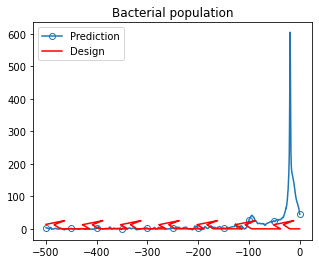

1 0.28289010748267174 loss =  863026.9375 loss_min =  345651.15625
2 0.2975946180522442 loss =  732033.125 loss_min =  345651.15625
3 0.2899120021611452 loss =  352042.46875 loss_min =  345651.15625
4 0.2889596801251173 loss =  427052.3125 loss_min =  345651.15625
5 0.27101609855890274 loss =  404539.375 loss_min =  345651.15625
6 0.2832914050668478 loss =  663558.9375 loss_min =  345651.15625
7 0.2617731373757124 loss =  613467.3125 loss_min =  345651.15625
8 0.28320830687880516 loss =  474750.46875 loss_min =  345651.15625
9 0.2752124220132828 loss =  312402.5625 loss_min =  345651.15625
tensor([ 2.7276, -1.4892,  3.7874, -0.5778, -0.5772,  1.3108],
       grad_fn=<CloneBackward0>)
L_p, x1, x2, x3, x4, x5, h  =  71.65869140625 -35.829345703125 -13.188396453857422 -20.367910385131836 -35.372676849365234 -16.04635238647461 26.405611038208008


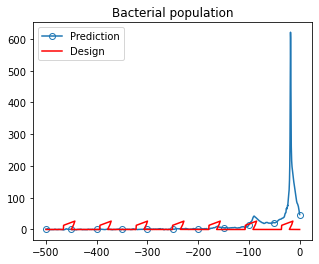

10 0.26649616472423077 loss =  357402.03125 loss_min =  312402.5625
11 0.2722043916583061 loss =  299860.03125 loss_min =  312402.5625
tensor([ 3.3904, -0.7894,  3.6179, -1.1264, -1.5572,  0.2691],
       grad_fn=<CloneBackward0>)
L_p, x1, x2, x3, x4, x5, h  =  66.19338989257812 -33.09669494628906 -20.67202377319336 -17.623682022094727 -23.90984344482422 -5.050836563110352 27.55182647705078


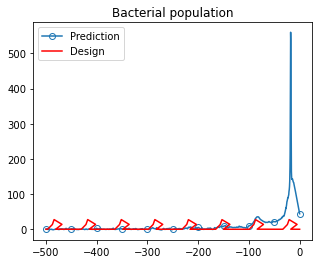

12 0.2574236560612917 loss =  308967.09375 loss_min =  299860.03125
13 0.267868472263217 loss =  311805.875 loss_min =  299860.03125
14 0.27009322866797447 loss =  479013.03125 loss_min =  299860.03125
15 0.27138252928853035 loss =  423615.53125 loss_min =  299860.03125
16 0.2726675681769848 loss =  352207.59375 loss_min =  299860.03125
17 0.2450945097953081 loss =  284298.71875 loss_min =  299860.03125
tensor([ 4.5988, -1.6127,  2.9714, -3.2385, -1.4068, -0.1458],
       grad_fn=<CloneBackward0>)
L_p, x1, x2, x3, x4, x5, h  =  61.89311599731445 -30.946557998657227 -10.287139892578125 -15.169439315795898 -24.225940704345703 -4.277365684509277 29.622587203979492


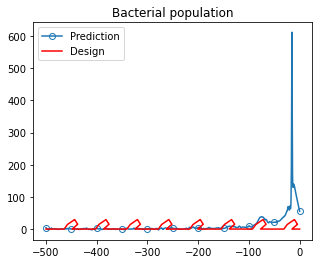

18 0.24220183677971363 loss =  369216.34375 loss_min =  284298.71875
19 0.2904686089605093 loss =  341445.5625 loss_min =  284298.71875
20 0.26897939294576645 loss =  316892.96875 loss_min =  284298.71875
21 0.26592655666172504 loss =  592009.0625 loss_min =  284298.71875
22 0.24245710112154484 loss =  232265.4375 loss_min =  284298.71875
tensor([ 5.2911, -0.7830,  4.1485, -2.6253, -2.7519, -1.0497],
       grad_fn=<CloneBackward0>)
L_p, x1, x2, x3, x4, x5, h  =  60.95204162597656 -30.47602081298828 -19.119094848632812 -15.235487937927246 -17.756290435791016 -0.7146492004394531 29.324726104736328


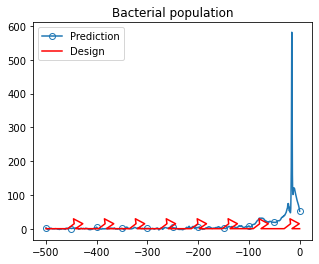

23 0.15440634451806545 loss =  668365.875 loss_min =  232265.4375
24 0.26703699119389057 loss =  265592.90625 loss_min =  232265.4375
25 0.2551366984844208 loss =  505191.0625 loss_min =  232265.4375
26 0.27145651169121265 loss =  419867.46875 loss_min =  232265.4375
27 0.2710198387503624 loss =  242629.71875 loss_min =  232265.4375
28 0.26904893666505814 loss =  314709.1875 loss_min =  232265.4375
29 0.2692581992596388 loss =  294375.09375 loss_min =  232265.4375
30 0.2694005239754915 loss =  718122.6875 loss_min =  232265.4375
31 0.26746454648673534 loss =  359763.65625 loss_min =  232265.4375
32 0.2720632776618004 loss =  313477.96875 loss_min =  232265.4375
33 0.2579543460160494 loss =  307711.84375 loss_min =  232265.4375
34 0.26544488966464996 loss =  315378.5 loss_min =  232265.4375
35 0.2617349233478308 loss =  257478.84375 loss_min =  232265.4375
36 0.2589800599962473 loss =  568023.625 loss_min =  232265.4375
37 0.24574108608067036 loss =  326128.0625 loss_min =  232265.4375


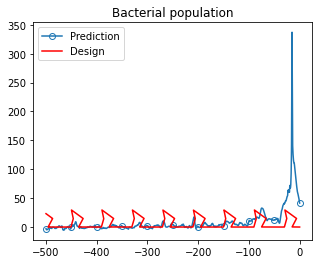

72 0.2472831755876541 loss =  285171.03125 loss_min =  222398.546875
73 0.22834635712206364 loss =  247464.96875 loss_min =  222398.546875
74 0.24833862483501434 loss =  304997.625 loss_min =  222398.546875
75 0.24946860410273075 loss =  298860.09375 loss_min =  222398.546875
76 0.26489855349063873 loss =  395733.5625 loss_min =  222398.546875
77 0.2479686737060547 loss =  370489.125 loss_min =  222398.546875
78 0.26537624932825565 loss =  315523.875 loss_min =  222398.546875
79 0.24775180965662003 loss =  266853.3125 loss_min =  222398.546875
80 0.25189088843762875 loss =  458062.34375 loss_min =  222398.546875
81 0.137528533115983 loss =  670690.25 loss_min =  222398.546875
82 0.24782945774495602 loss =  574007.8125 loss_min =  222398.546875
83 0.26597203500568867 loss =  296108.34375 loss_min =  222398.546875
84 0.250331649556756 loss =  495795.03125 loss_min =  222398.546875
85 0.15936734713613987 loss =  636600.75 loss_min =  222398.546875
86 0.23173398710787296 loss =  412974.312

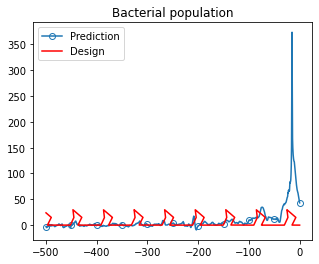

99 0.23262195102870464 loss =  206597.21875 loss_min =  206540.890625
100 0.2644643001258373 loss =  480285.96875 loss_min =  206540.890625
101 0.23119558580219746 loss =  586737.6875 loss_min =  206540.890625
102 0.26291769556701183 loss =  390127.4375 loss_min =  206540.890625
103 0.23487182334065437 loss =  333768.0 loss_min =  206540.890625
104 0.24732177145779133 loss =  267645.0625 loss_min =  206540.890625
105 0.2436741590499878 loss =  215751.453125 loss_min =  206540.890625
106 0.1376872304826975 loss =  693389.1875 loss_min =  206540.890625
107 0.23006907105445862 loss =  218374.859375 loss_min =  206540.890625
108 0.2413544300943613 loss =  312350.90625 loss_min =  206540.890625
109 0.14241607673466206 loss =  248762.359375 loss_min =  206540.890625
110 0.17470832541584969 loss =  549239.3125 loss_min =  206540.890625
111 0.2699826043099165 loss =  279060.6875 loss_min =  206540.890625
112 0.26509752683341503 loss =  249936.515625 loss_min =  206540.890625
113 0.284941136837

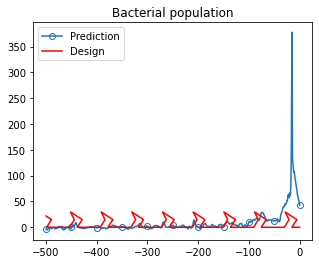

214 0.31132798455655575 loss =  598967.3125 loss_min =  206487.78125
215 0.3283692058175802 loss =  482755.4375 loss_min =  206487.78125
216 0.3300029467791319 loss =  384654.125 loss_min =  206487.78125
217 0.3225647173821926 loss =  292172.84375 loss_min =  206487.78125
218 0.3353083375841379 loss =  393114.28125 loss_min =  206487.78125
219 0.3527616560459137 loss =  697341.3125 loss_min =  206487.78125
220 0.30073942244052887 loss =  200972.59375 loss_min =  206487.78125
tensor([ 5.8536, -0.1526,  7.1565, -5.5681, -1.7676,  1.8740],
       grad_fn=<CloneBackward0>)
L_p, x1, x2, x3, x4, x5, h  =  60.54368209838867 -30.271841049194336 -27.966575622558594 -15.259942054748535 -21.641868591308594 -5.757943153381348 29.96196937561035


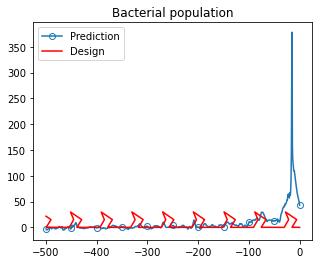

221 0.3357957173138857 loss =  307066.40625 loss_min =  200972.59375
222 0.3370739761739969 loss =  297492.84375 loss_min =  200972.59375
223 0.3179159499704838 loss =  232149.578125 loss_min =  200972.59375
224 0.3166445307433605 loss =  251371.078125 loss_min =  200972.59375
225 0.3313509002327919 loss =  223038.640625 loss_min =  200972.59375
226 0.31243642792105675 loss =  355302.0 loss_min =  200972.59375
227 0.3430782835930586 loss =  632449.875 loss_min =  200972.59375
228 0.3180724810808897 loss =  242437.796875 loss_min =  200972.59375
229 0.3121003955602646 loss =  234755.953125 loss_min =  200972.59375
230 0.31240458972752094 loss =  378291.53125 loss_min =  200972.59375
231 0.3294080886989832 loss =  349968.5625 loss_min =  200972.59375
232 0.3297687191516161 loss =  433750.625 loss_min =  200972.59375
233 0.3274684473872185 loss =  432972.375 loss_min =  200972.59375
234 0.31837197579443455 loss =  197164.890625 loss_min =  200972.59375
tensor([ 5.9656, -0.2424,  5.9642, -

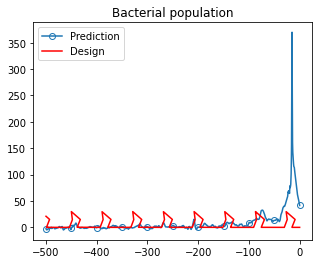

235 0.3002777546644211 loss =  361519.0 loss_min =  197164.890625
236 0.3193084243685007 loss =  788068.375 loss_min =  197164.890625
237 0.3143735099583864 loss =  554466.25 loss_min =  197164.890625
238 0.3196648545563221 loss =  237534.078125 loss_min =  197164.890625
239 0.3331542294472456 loss =  458749.09375 loss_min =  197164.890625
240 0.3204419016838074 loss =  357202.34375 loss_min =  197164.890625
241 0.3342370204627514 loss =  309495.65625 loss_min =  197164.890625
242 0.3116862829774618 loss =  400006.34375 loss_min =  197164.890625
243 0.3340992461889982 loss =  626901.9375 loss_min =  197164.890625
244 0.30127311684191227 loss =  376224.1875 loss_min =  197164.890625
245 0.31920704431831837 loss =  458323.0625 loss_min =  197164.890625
246 0.3183839861303568 loss =  202109.578125 loss_min =  197164.890625
247 0.3183052595704794 loss =  238975.734375 loss_min =  197164.890625
248 0.3280641417950392 loss =  250564.609375 loss_min =  197164.890625
249 0.3321683518588543 los

In [9]:
################################################################
# inverse optimization for 1d
################################################################


model = torch.load("catheter_plain_length_model_1d1000", map_location=device)
print(count_params(model))


epochs = 500


# constraints   
#               60 < L_p < 250
#               x1 = -0.5L_p 
#               
#               15 < x3 - x1 < L_p/2
#             -L_p < x2      < 0
#               20 < h       < 30
#             -L_p < x4  < -dx5_x4
#             dx5_x4 < x5 - x4  < 0 - x4 (dx5_x4 + x4 < x5 < 0)
# def transfer(theta):

dx5_x4 = 15

def transfer(theta):
    
    L_p = 60 + (250 - 60)/(1 + torch.exp(theta[0]))
    x1 = -0.5*L_p
    x3 = x1  + 15 + (L_p/2 - 15)/(1 + torch.exp(theta[2]))
    x2 = -L_p  + L_p/(1 + torch.exp(theta[1]))
    h = 20   + (10)/(1 + torch.exp(theta[3]))
    #
    x4 = -L_p  + (-dx5_x4 + L_p)/(1 + torch.exp(theta[4]))
    x5 = x4  + dx5_x4 + (-x4 - dx5_x4)/(1 + torch.exp(theta[5]))

    return L_p, x1, x2, x3, x4, x5, h


def inv_transfer(L_p, x2, x3, x4, x5, h):
    x1 = -0.5*L_p
    theta = np.zeros(6)

    theta[0] = np.log( (250 - 60)/(L_p - 60) - 1 )
    theta[1] = np.log( L_p/(x2 + L_p) - 1 )
    theta[2] = np.log( (L_p/2 - 15)/(x3 - x1  - 15) - 1 )
    theta[3] = np.log( 10/(h - 20 ) - 1 )
    
    theta[4] = np.log( (-dx5_x4 + L_p)/(x4 + L_p) - 1 )
    theta[5] = np.log( (-x4 - dx5_x4)/(x5 - x4  - dx5_x4) - 1 )    
    
    return theta


L_p, x2, x3, x4, x5, h = 100.0, -30.0, -30.0, -50.0, -30.0, 25.0, 

theta0 =    inv_transfer(L_p, x2, x3, x4, x5, h) 


theta = torch.tensor(theta0.astype(np.float32) , requires_grad=True)
print("initialize : ", transfer(theta))

optimizer = Adam([theta], lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

L_x = 500
N_s = 2001
xx_mask = (torch.linspace(1.0, 0, N_s) * (-L_x)).to(device)

max_iter = 100

optimizer = torch.optim.LBFGS([theta], max_iter=max_iter, lr=1.0, line_search_fn="strong_wolfe")

loss_min = torch.tensor(np.inf)
theta_min = torch.clone(theta)

for ep in range(epochs):
    t1 = default_timer()
    def loss_closure():
        
        L_p, x1, x2, x3, x4, x5, h = transfer(theta)
        x, XC, YC = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, x4, x5, h, N_s)
    
        optimizer.zero_grad()
        out = model(x).squeeze()
        loss = -torch.sum(torch.matmul(out, xx_mask))* L_x/N_s
        loss.backward()
        
        return loss
    
    
    optimizer.step(loss_closure)

    t2 = default_timer()
 
    if ep%1==0:
        
        L_p, x1, x2, x3, x4, x5, h = transfer(theta)
        x, XC, YC = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, x4, x5, h, N_s)
    
        out = model(x).squeeze()
        loss = -torch.sum(torch.matmul(out, xx_mask))* L_x/N_s
        print(ep, t2 - t1,  "loss = ", loss.item(), "loss_min = ", loss_min.item(),)
        
        
        if loss < loss_min:
            
            theta_min = torch.clone(theta)
            loss_min = loss
            print(theta_min)
            mesh = x.detach().cpu().numpy()
            print("L_p, x1, x2, x3, x4, x5, h  = ", L_p.item(), x1.item(), x2.item(), x3.item(), x4.item(), x5.item(), h.item())


            plt.figure(figsize=(5,4))
            plt.title("Bacterial population")
            plt.plot(xx_mask.detach().cpu().numpy(), out.detach().cpu().numpy().T, "-o", fillstyle='none', markevery=len(xx_mask)//10, label="Prediction")
            plt.plot(mesh[0, :, 0], mesh[0, :, 1], color="r", label="Design")

            plt.legend()
            plt.show()
            
        theta = theta_min + torch.normal(mean=0.0, std=torch.ones(len(theta)))
        
        
        
        
